# Import Libraries

In [12]:
# utilities
import re
import pickle
import nltk
nltk.download('wordnet')
import numpy as np
import pandas as pd
import tkinter as tk
from tkinter import filedialog
import sys
import nltk
nltk.download('omw-1.4')

import matplotlib.figure
import matplotlib.patches
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg

# plotting
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# nltk
from nltk.stem import WordNetLemmatizer
import snowballstemmer 

# sklearn
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

[nltk_data] Downloading package wordnet to /home/ashik/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/ashik/nltk_data...
[nltk_data]   Unzipping corpora/omw-1.4.zip.


In [7]:
# import the dataset
DATASET_COLUMNS  = ["sentiment", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
dataset = pd.read_csv('training.1600000.processed.noemoticon.csv', encoding=DATASET_ENCODING , names=DATASET_COLUMNS)

# dataset = pd.read_csv('training.1600000.processed.noemoticon.csv')

In [8]:
dataset.head()

,sentiment,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


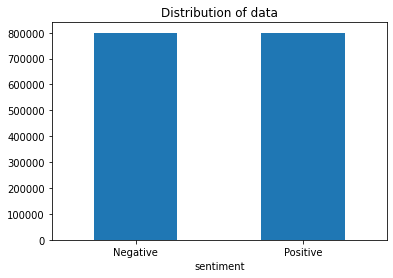

In [9]:
# remove unnecessary columns.
dataset = dataset[['sentiment','text']]

# replace the value 4 with 1
dataset['sentiment'] = dataset['sentiment'].replace(4,1)

# plot the distribution for dataset.
ax = dataset.groupby('sentiment').count().plot(kind='bar', title='Distribution of data',
                                               legend=False)

ax.set_xticklabels(['Negative','Positive'], rotation=0)

# store data in lists
text, sentiment = list(dataset['text']), list(dataset['sentiment'])

In [47]:
dataset.shape

(1600000, 2)

In [48]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 2 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   sentiment  1600000 non-null  int64 
 1   text       1600000 non-null  object
dtypes: int64(1), object(1)
memory usage: 24.4+ MB


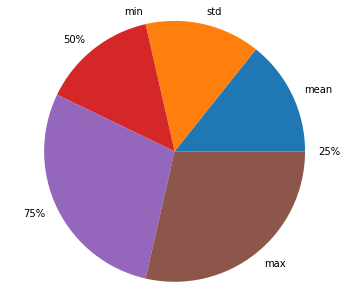

In [49]:
des_Val=[0.5,0.5,0.0,0.5,1.0,1.0,0.0]
des_labels=["mean","std","min","50%","75%","max","25%"]
plt.axis("equal")
plt.pie(des_Val,labels=des_labels,radius=1.5)
plt.show()

In [50]:
#check the distribution of target value
dataset['sentiment'].value_counts()

0    800000
1    800000
Name: sentiment, dtype: int64

# Preprocessing starts

In [4]:
# define dictionary containing all emojis with their meanings.
emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad', 
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed', 
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink', 
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}

## define set containing all stopwords in english.
stopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from', 
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're',
             's', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those', 
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves']

In [13]:
def preprocess(textdata):
    processedText = []
    
    # Create Lemmatizer and Stemmer.
    wordLemm = WordNetLemmatizer()
    
    # Defining regex patterns.
    urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
    userPattern       = '@[^\s]+'
    alphaPattern      = "[^a-zA-Z0-9]"
    sequencePattern   = r"(.)\1\1+"
    seqReplacePattern = r"\1\1"
    
    for tweet in textdata:
        tweet = tweet.lower()
        
        # Replace all URls with 'URL'
        tweet = re.sub(urlPattern,'',tweet)
        # Replace all emojis.
        for emoji in emojis.keys():
            tweet = tweet.replace(emoji, "EMOJI" + emojis[emoji])        
        # Replace @USERNAME to 'USER'.
        tweet = re.sub(userPattern,'', tweet)        
        # Replace all non alphabets.
        tweet = re.sub(alphaPattern, " ", tweet)
        # Replace 3 or more consecutive letters by 2 letter.
        tweet = re.sub(sequencePattern, seqReplacePattern, tweet)

        # stem words with snowball stemmer
        

        stemmer = snowballstemmer.stemmer('english')
        stemmer.stemWords(tweet)


        tweetwords = ''
        for word in tweet.split():
            # Checking if the word is a stopword.
            #if word not in stopwordlist:
            if len(word)>1 and (word not in stopwordlist):
                # Lemmatizing the word.
                word = wordLemm.lemmatize(word)
                tweetwords += word+' '

        processedText.append(tweetwords)
        
    return processedText

In [14]:
import time

t = time.time()
processedtext = preprocess(text)
print(f'Text Preprocessing complete.')
print(f'Time Taken: {round(time.time()-t)} seconds')

Text Preprocessing complete.
Time Taken: 617 seconds


In [15]:
#checking missing value
dataset.isnull().sum()

sentiment    0
text         0
dtype: int64

In [56]:
dataset.describe()

,sentiment
count,1600000.0
mean,0.5
std,0.5
min,0.0
25%,0.0
50%,0.5
75%,1.0
max,1.0


In [16]:
processedtext[:5]

['aww bummer shoulda got david carr third day EMOJIwink ',
 'upset update facebook texting might cry result school today also blah ',
 'dived many time ball managed save 50 rest go bound ',
 'whole body feel itchy like fire ',
 'no not behaving mad see over ']

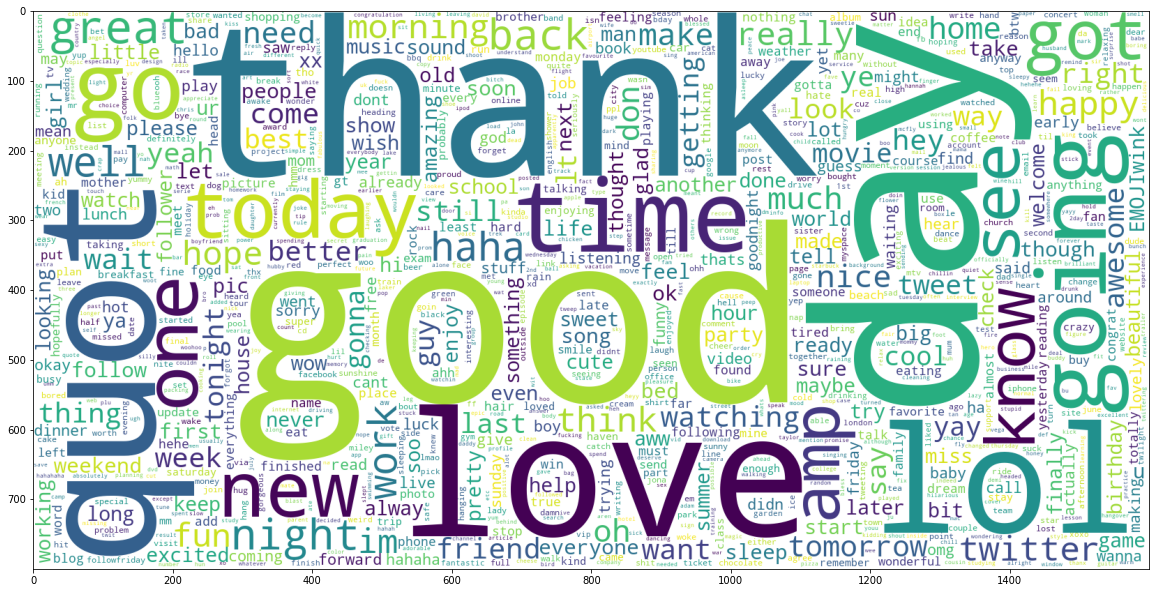

In [17]:
data_pos = processedtext[800000:]
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800, background_color ='white', 
              collocations=False).generate(" ".join(data_pos))
plt.figure(figsize = (20,20))
plt.imshow(wc)

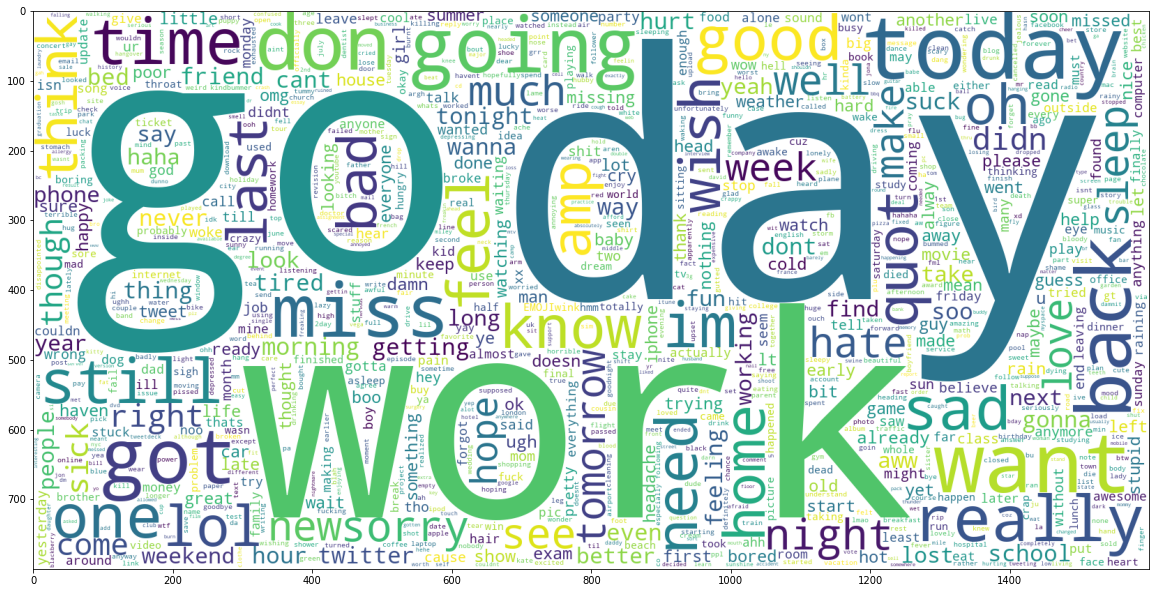

In [18]:
data_neg = processedtext[:800000]
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800, background_color ='white',
               collocations=False).generate(" ".join(data_neg))
plt.imshow(wc)

In [19]:
X_train, X_test, y_train, y_test = train_test_split(processedtext, sentiment, train_size = .95,
                                                    test_size = 0.05, random_state = 0)
print(f'Data Split done.')

Data Split done.


In [61]:
X_train[:5]

['working double texas roadhouse ',
 'envy everyone thats not working today nice day ',
 'hehe thanks everyone class laughing ',
 'woot woot haha gonna go movie uncle iphone ',
 'pissed use crappy phone til get new one ']

In [20]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
vec=vectorizer.fit_transform(X_train[:5])
vectorizer.get_feature_names_out()

array(['class', 'crappy', 'day', 'double', 'envy', 'everyone', 'get',
       'go', 'gonna', 'haha', 'hehe', 'iphone', 'laughing', 'movie',
       'new', 'nice', 'not', 'one', 'phone', 'pissed', 'roadhouse',
       'texas', 'thanks', 'thats', 'til', 'today', 'uncle', 'use', 'woot',
       'working'], dtype=object)

In [64]:
print(vec.toarray())

[[0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1]
 [0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1 0 1 0 0 0 1]
 [1 0 0 0 0 1 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 1 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 2 0]
 [0 1 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 1 1 1 0 0 0 0 1 0 0 1 0 0]]


In [21]:
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
vectoriser.fit(X_train)
print(f'Vectoriser fitted.')
print('No. of feature_words: ', len(vectoriser.get_feature_names()))

Vectoriser fitted.


/home/ashik/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


No. of feature_words:  500000


In [24]:
X_train = vectoriser.transform(X_train)
X_test  = vectoriser.transform(X_test)
print(f'Data Transformed.')

Data Transformed.


In [25]:
from sklearn.metrics import accuracy_score
def model_Evaluate(model):
    # Predict values for Test dataset
    y_pred = model.predict(X_test)
    # Print the evaluation metrics for the dataset.
    print(classification_report(y_test, y_pred))
    
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)

    categories  = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)
    # return accuracy_score(y_test, y_pred)

              precision    recall  f1-score   support

           0       0.74      0.67      0.70     39989
           1       0.70      0.77      0.73     40011

    accuracy                           0.72     80000
   macro avg       0.72      0.72      0.72     80000
weighted avg       0.72      0.72      0.72     80000



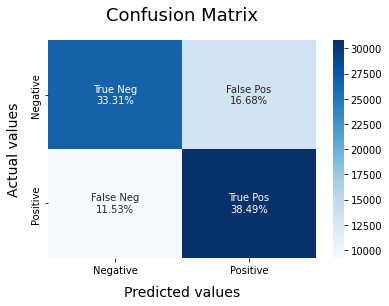

In [26]:
rf = RandomForestClassifier(n_estimators = 20, criterion = 'entropy', max_depth=50)
rf.fit(X_train, y_train)
model_Evaluate(rf)
rf_acc = accuracy_score(rf.predict(X_test), y_test)

In [28]:
rf_acc

0.7179625

              precision    recall  f1-score   support

           0       0.81      0.79      0.80     39989
           1       0.79      0.81      0.80     40011

    accuracy                           0.80     80000
   macro avg       0.80      0.80      0.80     80000
weighted avg       0.80      0.80      0.80     80000



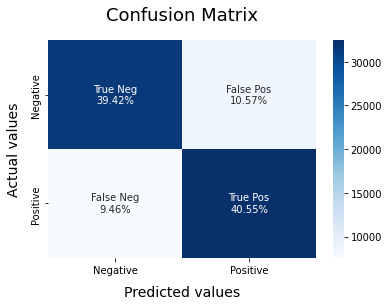

In [29]:
SVCmodel = LinearSVC()
SVCmodel.fit(X_train, y_train)
model_Evaluate(SVCmodel)
SVCmodel_acc = accuracy_score(SVCmodel.predict(X_test), y_test)

In [30]:
SVCmodel_acc

0.7997125

              precision    recall  f1-score   support

           0       0.81      0.77      0.79     39989
           1       0.78      0.82      0.80     40011

    accuracy                           0.79     80000
   macro avg       0.79      0.79      0.79     80000
weighted avg       0.79      0.79      0.79     80000



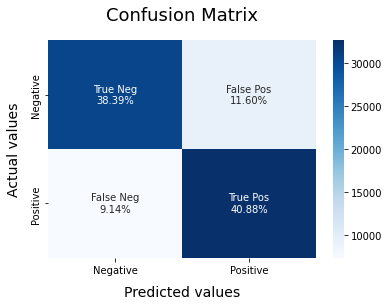

In [31]:
# alpha (laplacian smoothing value) = 2
BNBmodel = BernoulliNB(alpha = 2)
BNBmodel.fit(X_train, y_train)
model_Evaluate(BNBmodel)
BNBmodel_acc = accuracy_score(BNBmodel.predict(X_test), y_test)

In [32]:
BNBmodel_acc

0.792675

              precision    recall  f1-score   support

           0       0.82      0.80      0.81     39989
           1       0.81      0.82      0.82     40011

    accuracy                           0.81     80000
   macro avg       0.81      0.81      0.81     80000
weighted avg       0.81      0.81      0.81     80000



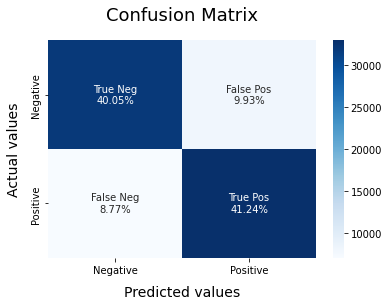

In [33]:
LRmodel = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)
LRmodel.fit(X_train, y_train)
model_Evaluate(LRmodel)
LRmodel_acc = accuracy_score(LRmodel.predict(X_test), y_test)

In [34]:
LRmodel_acc

0.8129625

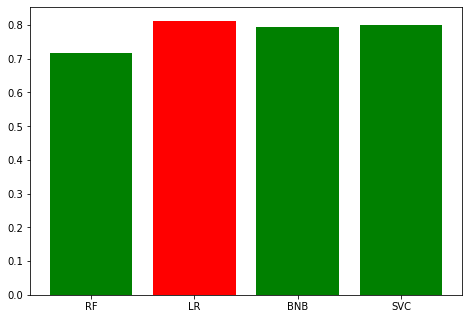

In [35]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
alogs = ['RF', 'LR', 'BNB', 'SVC']
algo_accs = [rf_acc, LRmodel_acc, BNBmodel_acc, SVCmodel_acc]
ax.bar(alogs,algo_accs, color = 'm')
plt.bar(alogs, algo_accs, color=['green', 'red', 'green', 'green'])
plt.show()

In [36]:
ds_test = pd.read_csv('S_D_test_dataset - Sheet1.csv')

In [37]:
ds_test.head()

,sentiment,text
0,0,Hot sunny day is always regrettable to me
1,1,I like to go there as I like the weather vey much
2,1,How nice! I love to see this winter weather
3,0,i got a serious pain and feeling lost
4,0,"they did not provide milk, I am very disappointed"


In [38]:
ds_test_txt, ds_test_sentiment = list(ds_test['text']), list(ds_test['sentiment'])

In [39]:
ds_test_txt[:5]

['Hot sunny day is always regrettable to me',
 'I like to go there as I like the weather vey much',
 'How nice! I love to see this winter weather',
 'i got a serious pain and feeling lost',
 'they did not provide milk, I am very disappointed']

In [40]:
ds_test.shape

(20, 2)

In [41]:
ds_test_txt = vectoriser.transform(preprocess(ds_test_txt))

In [49]:
from sklearn.metrics import accuracy_score
def test_model_Evaluate(model):
    # Predict values for Test dataset
    y_pred = model.predict(ds_test_txt)
    # Print the evaluation metrics for the dataset.
    print(classification_report(ds_test_sentiment, y_pred))
    
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(ds_test_sentiment, y_pred)

    categories  = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

              precision    recall  f1-score   support

           0       0.85      0.92      0.88        12
           1       0.86      0.75      0.80         8

    accuracy                           0.85        20
   macro avg       0.85      0.83      0.84        20
weighted avg       0.85      0.85      0.85        20



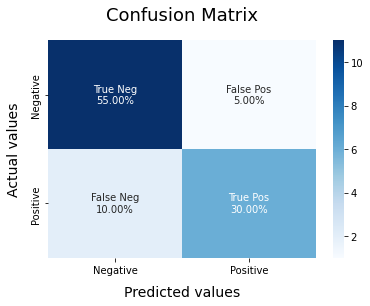

In [43]:
test_BNBmodel = BernoulliNB(alpha = 2)
test_BNBmodel.fit(X_train, y_train)
test_model_Evaluate(test_BNBmodel)
test_BNBmodel_acc = accuracy_score(test_BNBmodel.predict(ds_test_txt), ds_test_sentiment)

In [44]:
test_BNBmodel_acc

0.85

In [45]:
def predict(vectoriser, model, text):
    # Predict the sentiment
    textdata = vectoriser.transform(preprocess(text))
    sentiment = model.predict(textdata)
    
    # Make a list of text with sentiment.
    data = []


    # map the text with the sentiment
    for text, pred in zip(text, sentiment):
        data.append((text,pred))
       
    # Convert the list into a Pandas DataFrame.
    # df = pd.DataFrame(data, columns = ['text','sentiment'])
    # df = df.replace([0,1], ["Negative","Positive"])
    return 'Negative' if pred == 0 else 'Positive', text



if __name__=="__main__":

    txt = []
    inp = input()
    txt.append(inp)
  
    result, text = predict(vectoriser, LRmodel, txt)
    print("The text :", text)
    print("The sentiment : ", result)

i am really good at coding
The text : i am really good at coding
The sentiment :  Positive


# Front end preparation

In [46]:
def analyse_file(path):
    pos=0
    neg=0
    DATASET_COLUMNS_2  = ["text"]
    DATASET_ENCODING = "ISO-8859-1"
    dataset_to_analyse = pd.read_csv(path, encoding=DATASET_ENCODING , names=DATASET_COLUMNS_2)
    txt=list(dataset_to_analyse["text"])
    for i in txt:
        p,pp=predict(vectoriser, LRmodel, [i])
        print(p)
        if p=="Positive":
            pos=pos+1
        elif p=="Negative":
            neg=neg+1
    print(pos,neg)
    return pos,neg
        

In [52]:
root=tk.Tk()
canvas=tk.Canvas(root, height="150", width="700",bg='#926310')

e=tk.Entry(root,width=100)
canvas.create_window(50 ,20, window=e)
e.place(x=30, y=20, width=500, height=25)
canvas.pack()


output=tk.Text(root,height=1,width=20)
canvas.create_window(200 ,60, window=output)
output.place(relx=0.5, rely=0.125, anchor=tk.CENTER)
canvas.pack()


def button_b():
    p=[]
    p.append(e.get())
    df,p = predict(vectoriser, LRmodel, p)
    output.delete("0.0","end")
    output.insert("0.0",df)
    if df=="Positive":
        output.tag_add("output_color","0.0", "1.30")
        output.tag_configure("output_color", foreground='green')
    if df=="Negative":
        output.tag_add("output_color","0.0", "1.30")
        output.tag_configure("output_color", foreground='red')
    e.delete(0,len(e.get()))
b=tk.Button(root,width=10,text="print",command=button_b)
canvas.create_window(600 ,30, window=b)
canvas.pack()


file_path=tk.Entry(root,width=100)
canvas.create_window(50 ,20, window=file_path)
file_path.place(x=30, y=80, width=500, height=25)
canvas.pack()
file_path2="None" 
def button_select_file():
    
    global file_path2
    file_path2 = filedialog.askopenfilename()
    print(file_path2)
    file_path.delete(0,len(file_path.get()))
    file_path.insert(0,file_path2)
    
    
b_select_file=tk.Button(root,width=10,text="Select File",command=button_select_file)
canvas.create_window(600 ,90, window=b_select_file)
canvas.pack()

fig = matplotlib.figure.Figure(figsize=(5,5))
ax = fig.add_subplot(111)
circle=matplotlib.patches.Circle( (0,0), 0, color='black')
ax.add_artist(circle)
canvas2 = FigureCanvasTkAgg(fig, master=root)
canvas2.get_tk_widget().pack()
canvas2.draw()

def button_analyze_file():
    global file_path2
    if file_path2=="None":
        return
    pos,neg=analyse_file(file_path2)
    ax.pie([pos,neg], radius=1, labels=["Positive","Negative"],autopct='%0.2f%%', shadow=False,)
    canvas2.draw()
b_analyze_file=tk.Button(root,width=10,text="Analyze Data",command=button_analyze_file)
canvas.create_window(200 ,130, window=b_analyze_file)
b_analyze_file.place(relx=0.5, rely=0.25, anchor=tk.CENTER)
canvas.pack()

root.mainloop()

/home/ashik/AI_projects_all/sentiment_analysis_on_social_media_texts/test_dataset_01.csv
Positive
Negative
Positive
Negative
Positive
Negative
Negative
Negative
Positive
Negative
Negative
4 7
/home/ashik/AI_projects_all/sentiment_analysis_on_social_media_texts/test_dataset_01.csv
Positive
Negative
Positive
Negative
Positive
Negative
Negative
Negative
Positive
Negative
Negative
4 7
Positive
Negative
Positive
Negative
Positive
Negative
Negative
Negative
Positive
Negative
Negative
4 7
Positive
Negative
Positive
Negative
Positive
Negative
Negative
Negative
Positive
Negative
Negative
4 7
Positive
Negative
Positive
Negative
Positive
Negative
Negative
Negative
Positive
Negative
Negative
4 7
Positive
Negative
Positive
Negative
Positive
Negative
Negative
Negative
Positive
Negative
Negative
4 7
Positive
Negative
Positive
Negative
Positive
Negative
Negative
Negative
Positive
Negative
Negative
4 7
